In [1]:
import os
from tqdm.notebook import tqdm

In [ ]:
# Parameters
file_suffix = '56234'
file_path = f'../soeren_syllable_data/results_h5/results_kappa_scan_{file_suffix}.h5'
mouse_ids = list(range(16, 23))
include_latent_state = True
tracking_prefix_func = lambda s: f'../soeren_syllable_data/TrackingData_mus{s}.csv'
fiber_prefix_func = lambda s: f'../soeren_syllable_data/sig_data_with_Scaled_zDFF_mus{s}.csv'
parameters = {
    'm': 150,
    'n': 150,
    'normalization_frame': 0,
    'window_size': 15,
    'min_snippets_required': 10,
    # Add other parameters as needed
}
save_figs = False

In [3]:
import keypoint_moseq as kpms

In [4]:
kpms.setup_project('./proj_example', deeplabcut_config='../soeren_syllable_data/config.yaml', overwrite=False)

In [4]:
kpms.update_config(
    './proj_example',
    video_dir=video_path,
    anterior_bodyparts=['Mouth'],
    posterior_bodyparts=['Butt/Proximal Tail'],
    use_bodyparts=[
        'Mouth',
        'Hind Paw R',
        'Hind Paw L',
        'Front Paw R',
        'Front Paw L',
        'Butt/Proximal Tail',
        'Stomach'
    ],
    skeleton=[
        ['Front Paw L', 'Stomach'],
        ['Hind Paw L', 'Butt/Proximal Tail'],
        ['Butt/Proximal Tail', 'Stomach'],
        ['Hind Paw R', 'Butt/Proximal Tail'],
        ['Mouth', 'Stomach'],
        ['Front Paw R', 'Stomach']
    ]
)


In [5]:
# load data (e.g. from DeepLabCut)
coordinates, confidences, bodyparts = kpms.load_keypoints(video_path + '/*DLC*.csv', 'deeplabcut')

Loading keypoints: 100%|████████████████| 19/19 [00:18<00:00,  1.02it/s]


In [ ]:
from copy import deepcopy
original_coords = deepcopy(coordinates)

In [6]:
for k, v in coordinates.items():
    k_numeric = int(k.split('_')[0][1:])
    if k_numeric <= 12:
        coordinates[k] *= 1.184

In [7]:
import re
import numpy as np
import os

# Function to normalize the filename by removing the 'trimmed/' prefix
def normalize_filename(filename):
    return os.path.basename(filename)  # Extract just the filename

def read_frame_indices(file_path):
    """Reads the frame indices from the given file using regex."""
    frame_indices = {}
    # Define the regex pattern to capture filename and start/end frames
    pattern = re.compile(r'(trimmed/[\w\-\.]+): Frame indices (\d+) to (\d+)')
    
    with open(file_path, 'r') as f:
        for line in f:
            match = pattern.match(line)
            if match:
                filename = normalize_filename(match.group(1))
                start_frame = int(match.group(2))
                end_frame = int(match.group(3))
                frame_indices[filename] = (start_frame, end_frame)
    return frame_indices

def subset_dict_by_frame_indices(data_dict, frame_indices):
    """Returns a new dict with subsets of the values (numpy arrays) based on the frame indices."""
    new_dict = {}
    for filename, (start_frame, end_frame) in frame_indices.items():
        # Find the first key that contains the filename (without extensions)
        matching_key = next((key for key in data_dict if filename.split('.')[0] in key), None)
        if matching_key:
            # Subset the NumPy array using the frame indices
            new_dict[matching_key] = data_dict[matching_key][start_frame:end_frame]
        else:
            print(f"File {filename} not found in data_dict.")
    return new_dict

In [8]:
# Path to the frame indices file (replace with your file path)
frame_indices_file = os.path.join(video_path, 'trimmed', 'frame_indices.txt')

# Read the frame indices from the file using regex
frame_indices = read_frame_indices(frame_indices_file)

# Update both coordinates and confidences dictionaries
coordinates = subset_dict_by_frame_indices(coordinates, frame_indices)
confidences = subset_dict_by_frame_indices(confidences, frame_indices)

In [9]:
# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())

In [10]:
#import os
#files = os.listdir(video_path)

#csv_files = [f for f in files if f.endswith('DLC.csv')]
#video_files = [f for f in files if f.startswith('Tracking_video') and f.endswith('.avi')]

# Create the mapping dictionary
# For each video file, find the CSV file that contains its unique identifier
#record_to_video = {
#    csv.replace('.csv', ''): video_path + '/' + video
#    for video in video_files
#    for csv in csv_files
#    if video.replace('Tracking_video', '').replace('.avi', '') in csv
#}

In [11]:
# kpms.noise_calibration(project_dir, coordinates, confidences, **config())

In [12]:
# skip calibration for now

#kpms.noise_calibration(project_dir, coordinates, confidences, **config())
kpms.calibration.load_annotations(project_dir);

In [13]:
# pca = kpms.fit_pca(**data, **config())
# kpms.save_pca(pca, project_dir)

# kpms.print_dims_to_explain_variance(pca, 0.9)
# kpms.plot_scree(pca, project_dir=project_dir)
# kpms.plot_pcs(pca, project_dir=project_dir, **config())

In [14]:
kpms.update_config(project_dir, latent_dim=7)

In [15]:
pca = kpms.load_pca(project_dir)

In [16]:
from jax_moseq.utils import set_mixed_map_iters
set_mixed_map_iters(4)

In [17]:
def generate_kappa_results(kappa, data, metadata, project_dir):
    # aiming for 30 frames
    kappa = kappa
    model_name = f'kappa_scan_1_{int(kappa)}'
    #model_name = '10_videos_300_iter_cohort2'

    num_ar_iters = 50
    model = kpms.init_model(data, pca=pca, **config())
    model = kpms.update_hypparams(model, kappa=kappa)
    model = kpms.fit_model(
        model, data, metadata, project_dir, model_name, generate_progress_plots=True,
        ar_only=True, num_iters=num_ar_iters, parallel_message_passing=False)[0]
    
    # load model checkpoint
    model, data, metadata, current_iter = kpms.load_checkpoint(
        project_dir, model_name, iteration=num_ar_iters)

    # modify kappa to maintain the desired syllable time-scale
    model = kpms.update_hypparams(model, kappa=kappa/10)

    # run fitting for an additional 500 iters
    model = kpms.fit_model(
        model, data, metadata, project_dir, model_name, ar_only=False, 
        start_iter=current_iter, num_iters=current_iter+200, parallel_message_passing=False)[0]
    
    return model_name

In [18]:
def generate_syllable_output(model_name, save_results=False):
    kpms.reindex_syllables_in_checkpoint(project_dir, model_name)
    model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)
    if save_results:
        results = kpms.extract_results(model, metadata, project_dir, model_name)
        kpms.save_results_as_csv(results, project_dir, model_name)
    else:
        results = kpms.load_results(project_dir, model_name)
    kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, pre=10, post=30, **config())
    #kpms.generate_grid_movies(results, project_dir, model_name, coordinates=original_coords, **config(), overlay_keypoints=True, fps=60)
    kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())

/home/gether-lab/miniconda3/envs/keypoint_moseq/lib/python3.9/site-packages/keypoint_moseq/fitting.py:589: UserWarning:

'kappa' with <class 'int'> will be cast to <class 'float'>



Outputs will be saved to
/mnt/nvmessd/soeren_kpms_salient/kappa_scan_0_300000000


 50%|██████████████████▌                  | 1/2 [00:09<00:09,  9.42s/it]

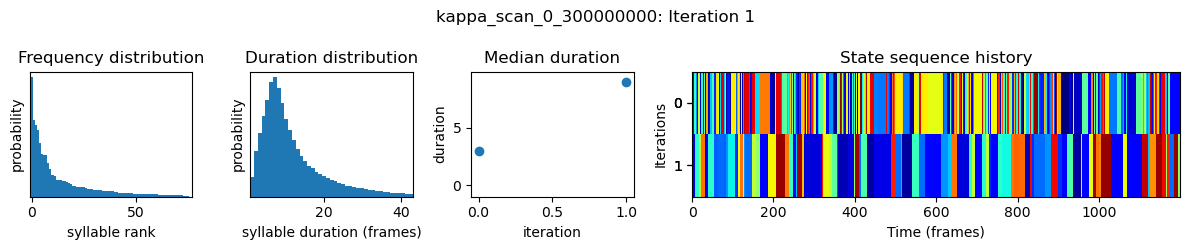

100%|█████████████████████████████████████| 2/2 [00:17<00:00,  8.73s/it]


Outputs will be saved to
/mnt/nvmessd/soeren_kpms_salient/kappa_scan_0_300000000


 50%|██████████████████▌                  | 1/2 [01:04<01:04, 64.39s/it]

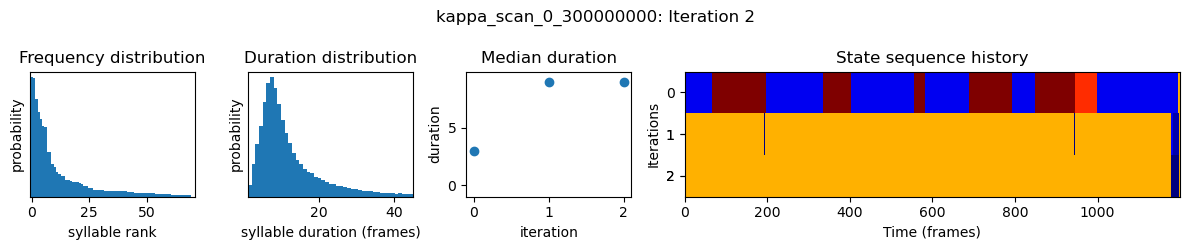

Reindexing: 100%|█████████████| 3/3 [00:01<00:00,  2.73model snapshot/s]


Saved results to
/mnt/nvmessd/soeren_kpms_salient/kappa_scan_0_300000000/results.h5


Saving to csv: 100%|████████████████████| 19/19 [00:08<00:00,  2.33it/s]


Saving trajectory plots to /mnt/nvmessd/soeren_kpms_salient/kappa_scan_0_300000000/trajectory_plots


Generating trajectory plots: 100%|██████| 32/32 [00:11<00:00,  2.70it/s]


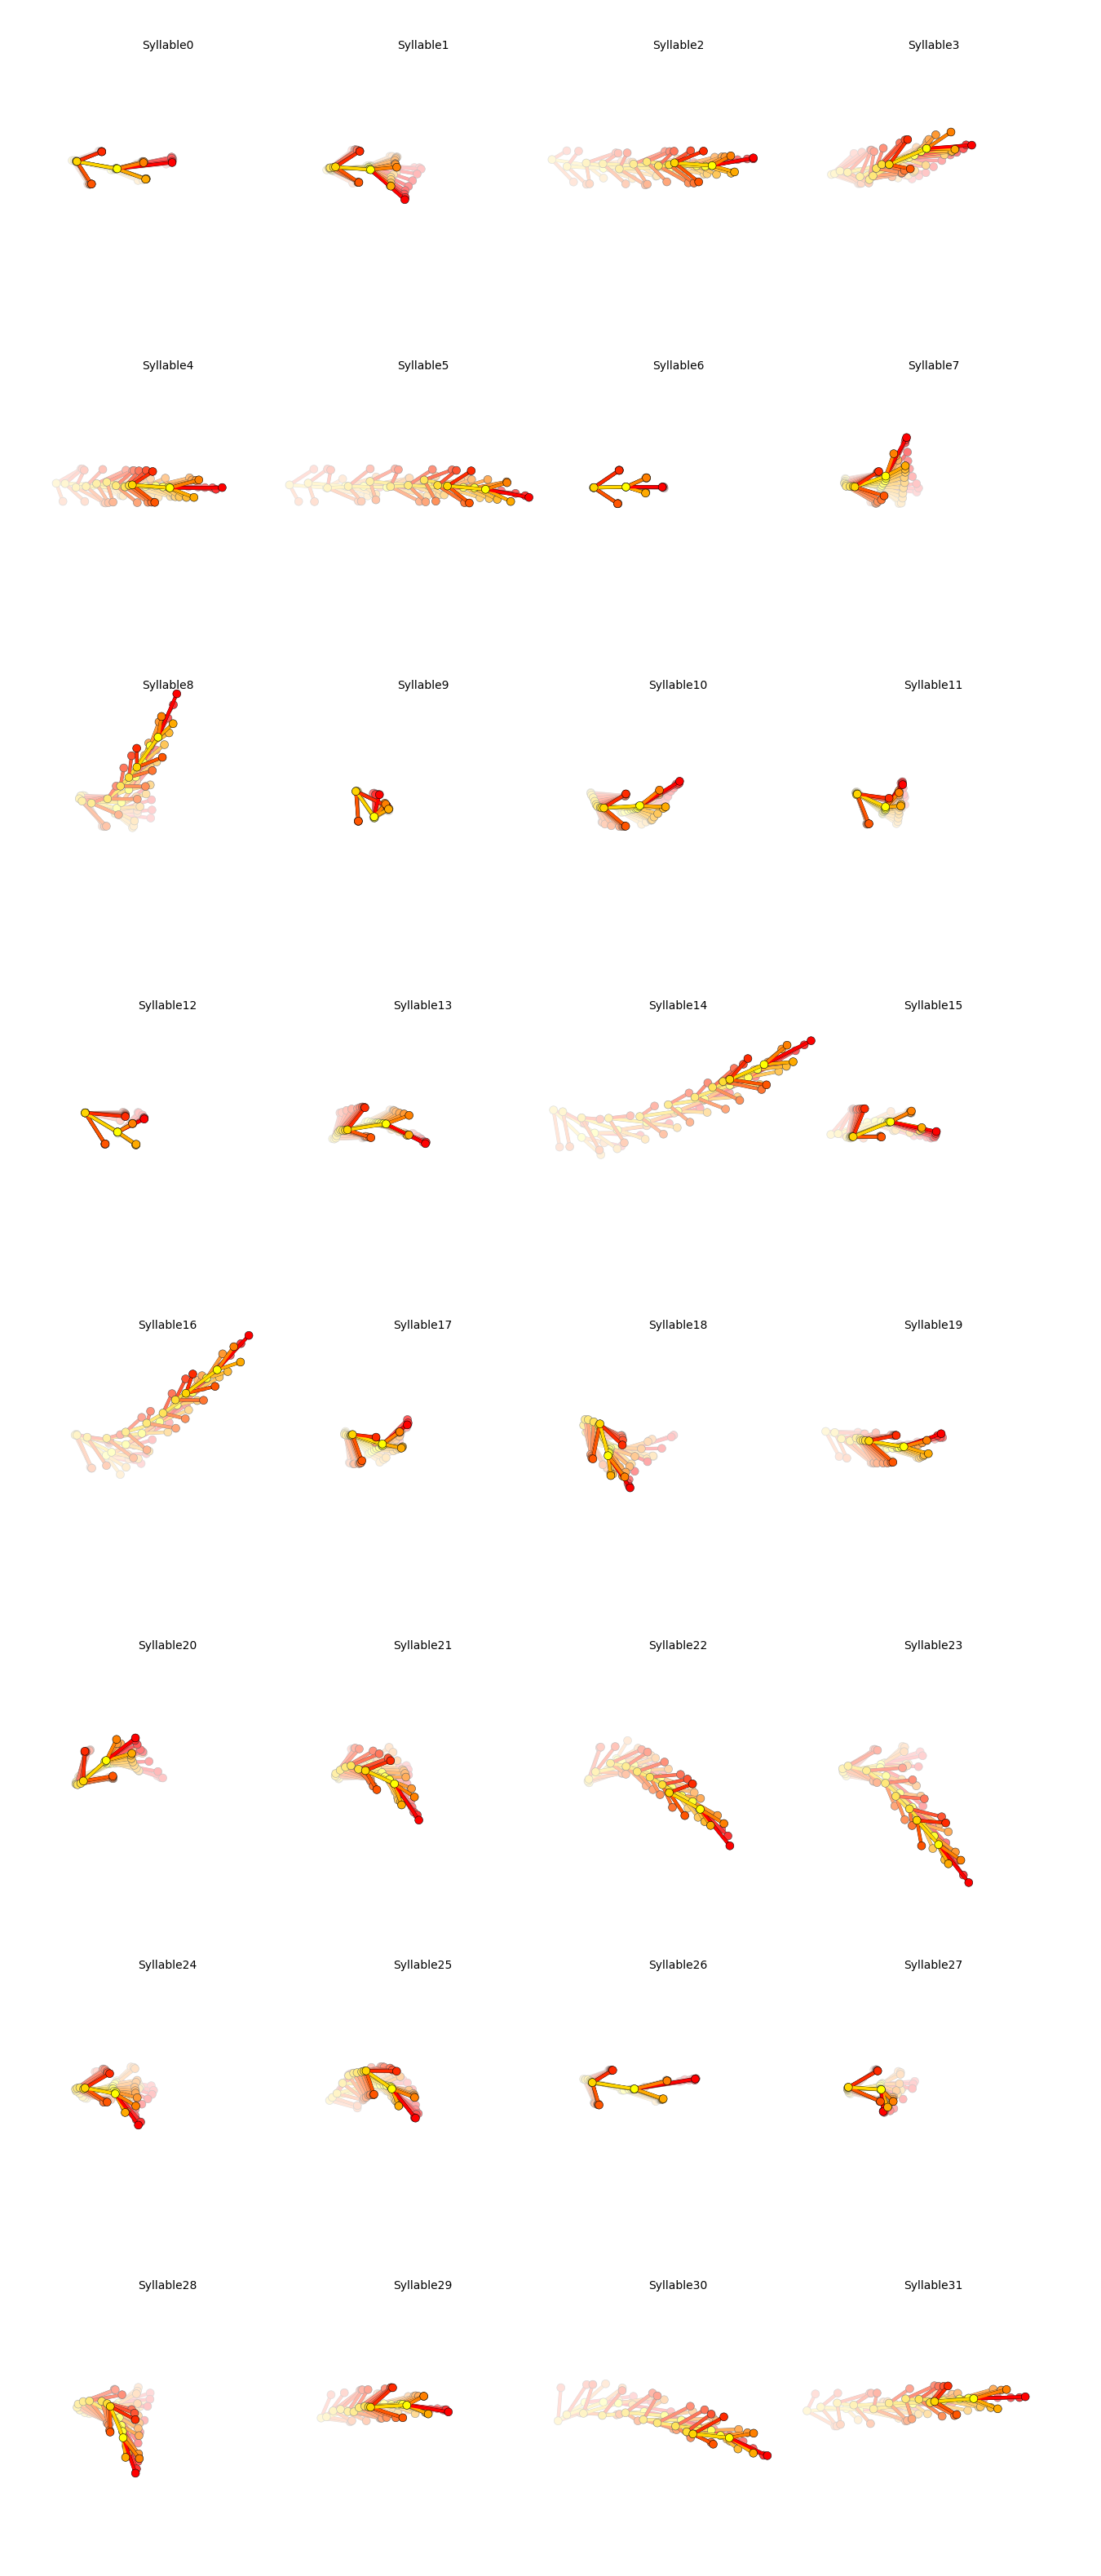

Writing grid movies to /mnt/nvmessd/soeren_kpms_salient/kappa_scan_0_300000000/grid_movies


/home/gether-lab/miniconda3/envs/keypoint_moseq/lib/python3.9/site-packages/keypoint_moseq/viz.py:1266: UserWarning:


Videos will be downscaled by a factor of 0.80 so that the grid movies
are under 1920 pixels. Use `max_video_size` to increase or decrease
this size limit.





Using window size of 400 pixels


Generating grid movies:  50%|█████▌     | 16/32 [02:53<02:50, 10.63s/it]pipe:: corrupt input packet in stream 0
[rawvideo @ 0x5c39180] Invalid buffer size, packet size 1703936 < expected frame_size 7372800
Generating grid movies:  50%|█████▌     | 16/32 [03:03<03:03, 11.48s/it]Error while decoding stream #0:0: Invalid argument



KeyboardInterrupt: 

: 

In [19]:
import numpy as npx

for kappa in [3 * 10**8, 10**9, 3 * 10**9]:
    model_name = generate_kappa_results(kappa, data, metadata, project_dir)
    #model_name = f'kappa_scan_2_{int(kappa)}'
    generate_syllable_output(model_name, True)